In [83]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import lightgbm as lgb
from sklearn import svm
import xgboost as xgb

import optuna

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [84]:
def load_data(y):
    path = '../../data/std_data/'
    x_train_std = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).values
    x_test_std = pd.read_pickle(path +'test/{}_x.pkl'.format(str(y))).values
    y_train = pd.read_pickle(path +'train/{}_y.pkl'.format(str(y))).values
    y_test = pd.read_pickle(path +'test/{}_y.pkl'.format(str(y))).values
    features = pd.read_pickle(path +'train/{}_x.pkl'.format(str(y))).columns
    return x_train_std, x_test_std, y_train, y_test, features

In [85]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [89]:
def train(w):
    
#     w_lr, w_lda, w_sv, w_xgb, w_lgbm = w
    
    w_lda, w_sv, w_xgb, w_lgbm = w
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all_lr = np.array([])
    probs_all_lda = np.array([])
    probs_all_sv = np.array([])
    probs_all_lgbm = np.array([])
    probs_all_xgb = np.array([])
    probs_all = np.array([])
    
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features = load_data(y)
        y_true_all = np.hstack((y_true_all, y_test))
       
        # logistic regression
#         lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l2", C=0.0001) # ロジスティック回帰モデルのインスタンスを作成
#         lr.fit(x_train_std, y_train) # ロジスティック回帰モデルの重みを学習
#         probs_lr = lr.predict_proba(x_test_std)
#         probs_all_lr = np.hstack((probs_all_lr, probs_lr[:,1]))
        
        # LDA
        lda = LDA(solver="eigen", shrinkage=1).fit(x_train_std,  y_train)
        probs_lda = lda.predict_proba(x_test_std)
        probs_all_lda = np.hstack((probs_all_lda, probs_lda[:,1]))
        
        # svm
        sv = svm.SVR(kernel="sigmoid",
                                     degree=4,
                                     gamma=0.043502212815589775,
                                     coef0=0.20190829020616494,
                                     tol=0.0001,
                                     C=0.000245786293391316,
                                     epsilon=0.3056167642389302,
                                    verbose=False,)
        sv.fit(x_train_std, y_train)
        probs_sv = sv.predict(x_test_std)
        probs_all_sv = np.hstack((probs_all_sv, probs_sv))
        
        # xgb
        xgboost = xgb.XGBRegressor(silent= True, 
                               max_depth=4,
                               learning_rate=0.12765177534095626,
                               n_estimators = 46,
                               gamma=0.060805284848630535,
                               reg_lambda=4.995675788308118,
                               reg_alpha=2.1912254426545754,
                               sub_sample=0.45297631180790854,
                               scale_pos_weight=1.1672978934986058)
        xgboost.fit(x_train_std, y_train)
        probs_xgb = xgboost.predict(x_test_std)
        probs_all_xgb = np.hstack((probs_all_xgb, probs_xgb))
        
        
        
        # lgbm
        lgbm = lgb.LGBMRegressor(
            random_state=0,
            verbosity=-1,
            bagging_seed=0,
            boost_from_average='true',
            metric='auc',
            bagging_freq=4,
            min_data_in_leaf=21,
            max_depth=13,
            learning_rate=0.08731913651405197,
            n_estimators=3394,
            subsample=0.7054763057027115,
            num_leaves=438,
            reg_lambda=0.9377125325944119,  
        )
        
        lgbm.fit(x_train_std, y_train)
        probs_lgbm = lgbm.predict(x_test_std)
        probs_all_lgbm = np.hstack((probs_all_lgbm, probs_lgbm))


        
#         probs = w_lda * probs_lda[:,1] + w_lr * probs_lr[:,1] + w_sv * probs_sv + w_xgb * probs_xgb + w_lgbm * probs_lgbm

        probs = w_lda * probs_lda[:,1] + w_sv * probs_sv + w_xgb * probs_xgb + w_lgbm * probs_lgbm
        
        probs_all = np.hstack((probs_all, probs))
#         print(probs)

        # 混同行列
        y_pred = np.where((probs ==  max(probs)), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
    
    
#     auc_lr = roc_auc_score(y_true_all, probs_all_lr)
    auc_lda = roc_auc_score(y_true_all, probs_all_lda)
    auc_sv = roc_auc_score(y_true_all, probs_all_sv)
    auc_xgb = roc_auc_score(y_true_all, probs_all_xgb)
    auc_lgbm = roc_auc_score(y_true_all, probs_all_lgbm)

    auc = roc_auc_score(y_true_all, probs_all)
    
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
#     print("AUC LR: ",auc_lr)
    print("AUC LDA: ",auc_lda)
    print("AUC svm: ",auc_sv)
    print("AUC xgb: ",auc_xgb)
    print("AUC lgbm: ", auc_lgbm)
    print("AUC all: ",auc)
    print()
    return auc

In [90]:
def main():
    np.set_printoptions(precision=3, suppress=True)
    
    auc_max = 0
    w_max = None
    
    for iter in range(100):
        print("iter", iter)
        # w = [w_lr, w_lda, w_lda, w_sv, w_xgb, w_lgbm]
        w = np.random.rand(4)
        w = w/np.sum(w)
        print("[w_lda, w_lda, w_sv, w_xgb, w_lgbm] = ", w)
        
        auc = train(w)
        if auc > auc_max:
            auc_max = auc
            w_max = w
        
    print("auc_max", auc_max)
    print(w_max)

iter 0
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.3   0.184 0.443 0.073]


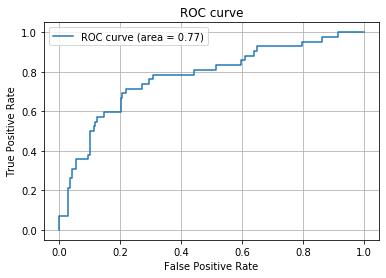

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7743026204564666

iter 1
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.315 0.45  0.101 0.133]


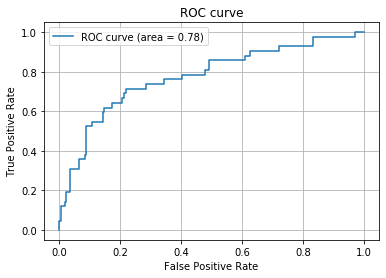

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7751479289940827

iter 2
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.45  0.079 0.172 0.298]


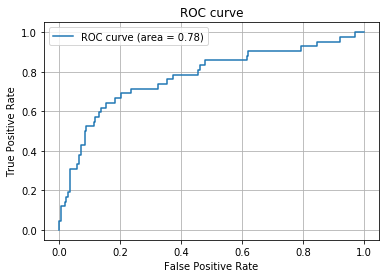

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.775570583262891

iter 3
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.319 0.302 0.061 0.318]


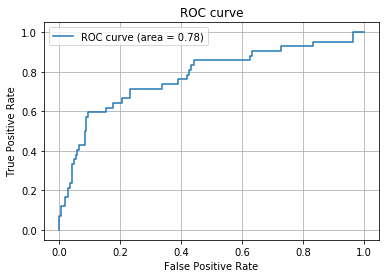

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7775429698506622

iter 4
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.118 0.454 0.379 0.049]


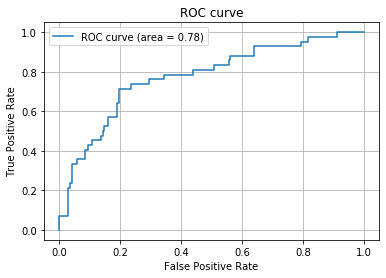

len: 211 , 211
confusion_matrix: 
[[152.  17.]
 [ 17.  25.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7751479289940828

iter 5
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.403 0.075 0.088 0.434]


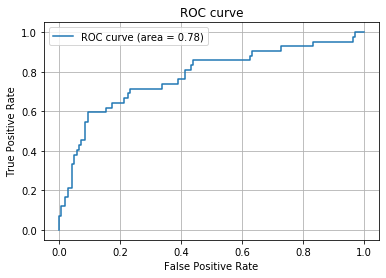

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7785291631445477

iter 6
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.174 0.271 0.352 0.202]


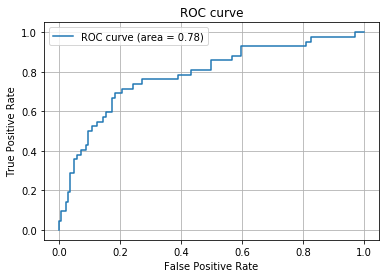

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7847280924204002

iter 7
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.052 0.004 0.341 0.602]


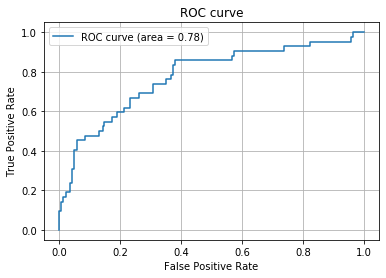

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7754296985066215

iter 8
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.112 0.421 0.154 0.314]


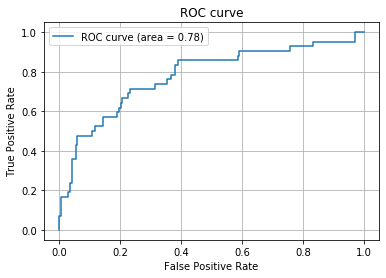

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7795153564384334

iter 9
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.185 0.354 0.097 0.364]


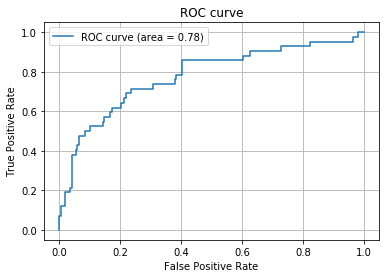

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7781065088757396

iter 10
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.088 0.107 0.542 0.263]


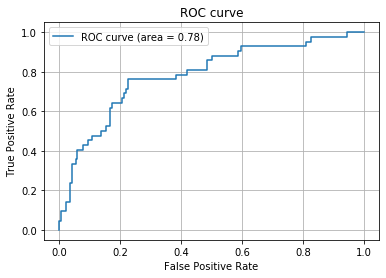

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7838827838827839

iter 11
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.494 0.037 0.039 0.43 ]


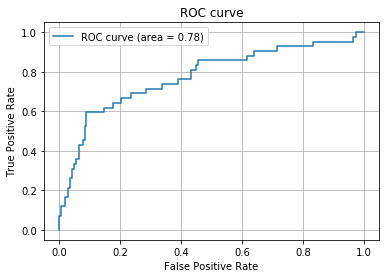

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7752888137503523

iter 12
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.457 0.197 0.11  0.236]


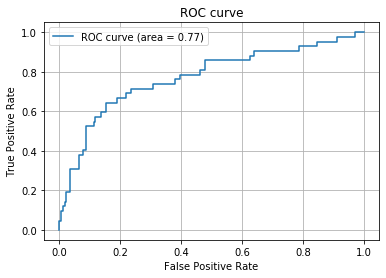

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7717666948436178

iter 13
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.289 0.178 0.175 0.359]


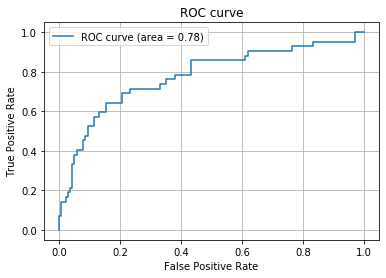

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7779656241194702

iter 14
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.193 0.094 0.513 0.2  ]


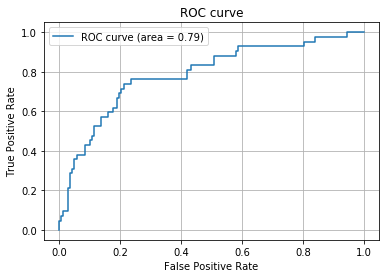

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7869822485207101

iter 15
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.304 0.163 0.392 0.141]


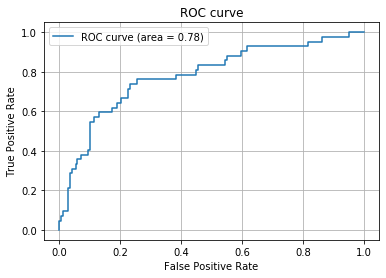

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7817695125387433

iter 16
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.332 0.511 0.014 0.143]


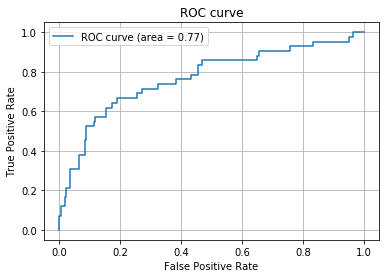

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7688081149619611

iter 17
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.116 0.415 0.169 0.3  ]


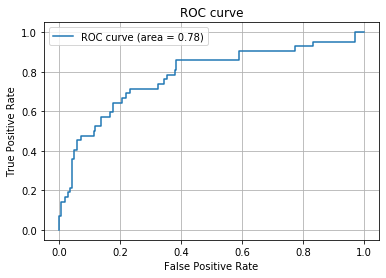

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7805015497323189

iter 18
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.237 0.086 0.267 0.409]


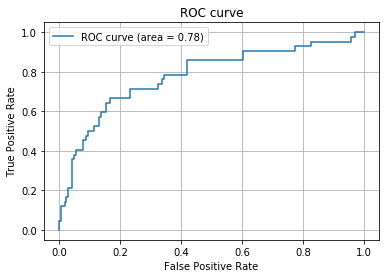

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7796562411947026

iter 19
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.031 0.381 0.023 0.566]


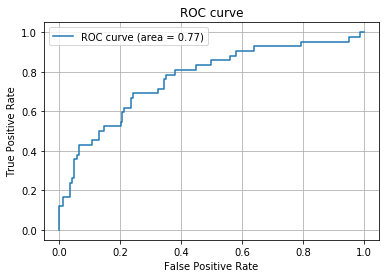

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7664130741053818

iter 20
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.12  0.281 0.388 0.211]


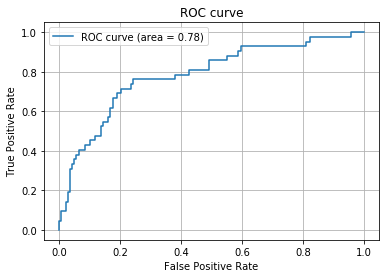

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7845872076641307

iter 21
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.345 0.285 0.349 0.02 ]


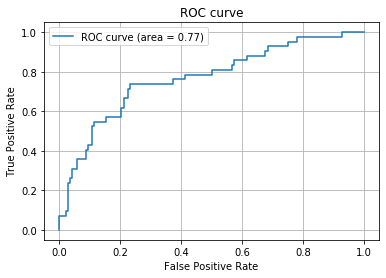

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7671174978867287

iter 22
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.072 0.503 0.284 0.141]


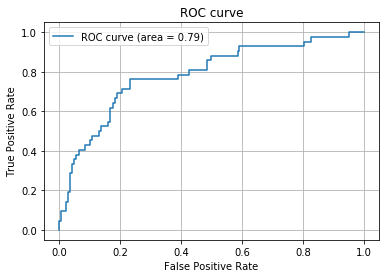

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7859960552268245

iter 23
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.278 0.263 0.355 0.105]


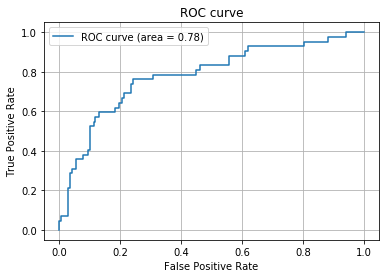

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7814877430262045

iter 24
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.2   0.343 0.242 0.215]


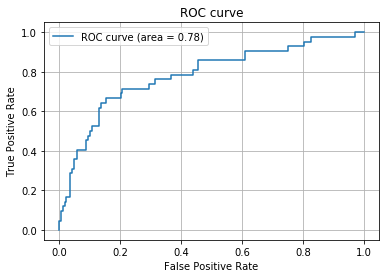

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7834601296139757

iter 25
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.334 0.301 0.18  0.184]


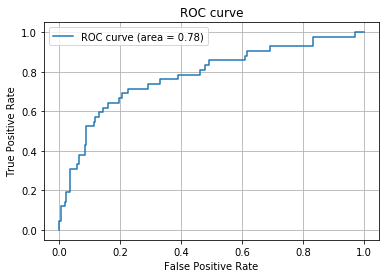

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7795153564384333

iter 26
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.294 0.294 0.189 0.223]


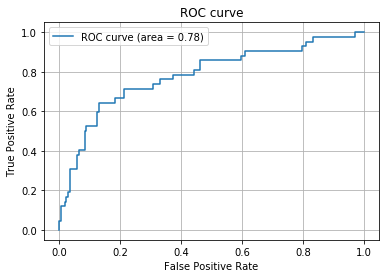

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7816286277824739

iter 27
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.273 0.272 0.347 0.107]


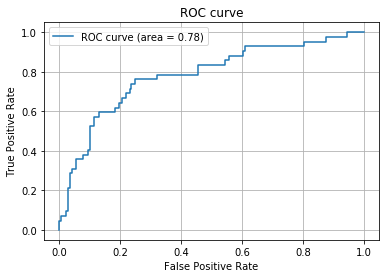

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.782051282051282

iter 28
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.218 0.224 0.418 0.14 ]


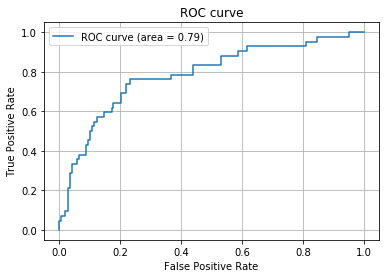

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7859960552268245

iter 29
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.181 0.599 0.026 0.194]


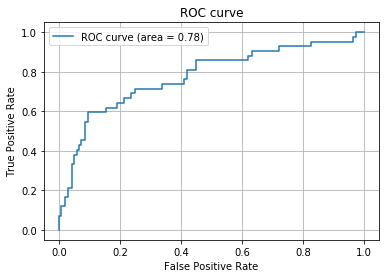

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7762750070442378

iter 30
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.495 0.18  0.134 0.191]


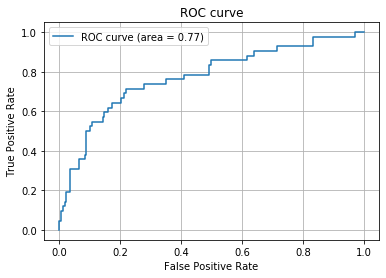

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7735981966751198

iter 31
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.412 0.096 0.444 0.048]


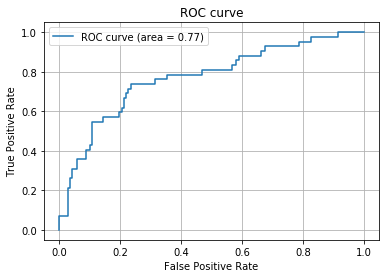

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7700760777683855

iter 32
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.264 0.288 0.263 0.185]


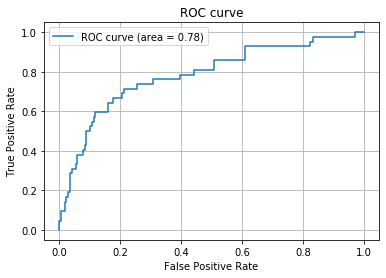

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7830374753451675

iter 33
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.256 0.36  0.027 0.357]


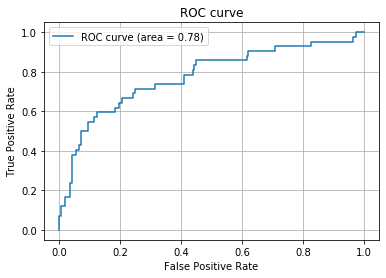

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7758523527754297

iter 34
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.222 0.416 0.069 0.293]


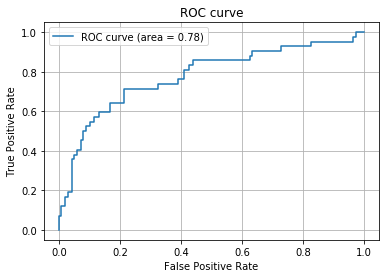

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7779656241194702

iter 35
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.354 0.169 0.241 0.236]


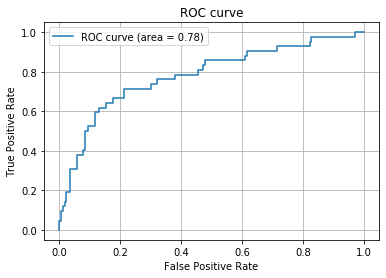

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7819103972950127

iter 36
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.263 0.382 0.026 0.329]


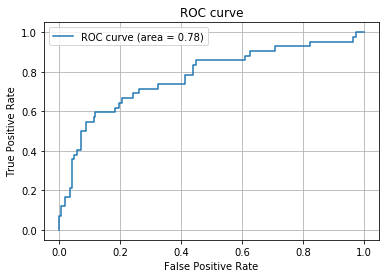

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7751479289940828

iter 37
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.185 0.127 0.494 0.194]


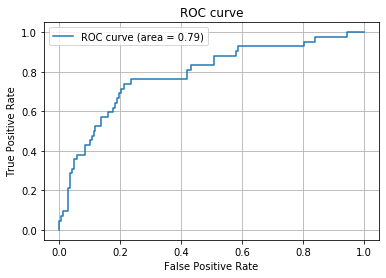

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7869822485207101

iter 38
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.177 0.312 0.223 0.288]


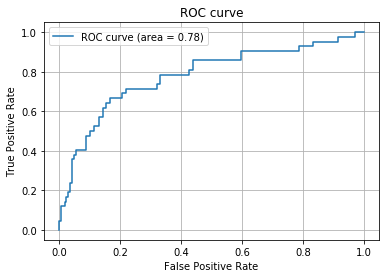

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7803606649760496

iter 39
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.261 0.025 0.601 0.114]


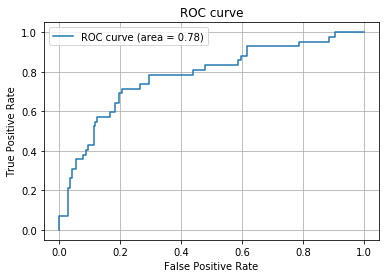

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7788109326570865

iter 40
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.014 0.479 0.3   0.208]


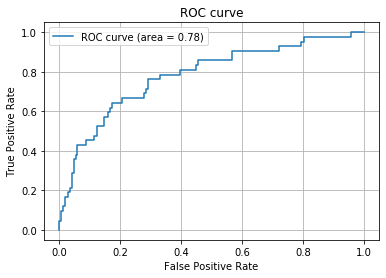

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7809242040011272

iter 41
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.404 0.09  0.265 0.24 ]


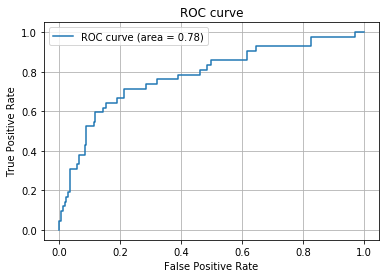

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7813468582699351

iter 42
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.191 0.317 0.134 0.358]


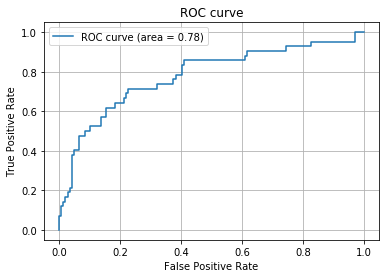

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7792335869258945

iter 43
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.369 0.091 0.283 0.257]


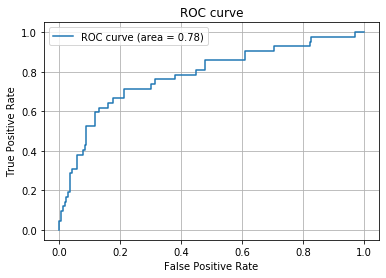

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7817695125387433

iter 44
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.473 0.265 0.096 0.166]


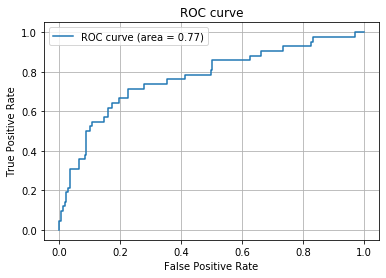

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7710622710622711

iter 45
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.144 0.384 0.239 0.234]


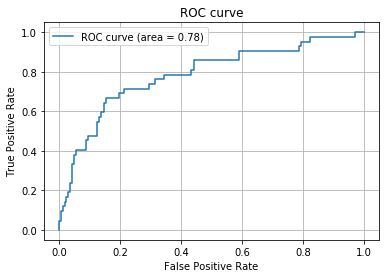

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7838827838827839

iter 46
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.562 0.05  0.218 0.17 ]


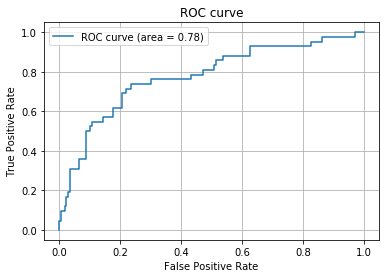

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7758523527754297

iter 47
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.089 0.141 0.413 0.357]


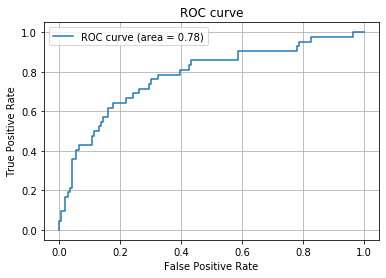

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7806424344885883

iter 48
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.322 0.195 0.312 0.171]


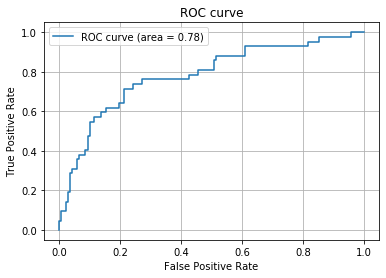

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7817695125387434

iter 49
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.313 0.127 0.248 0.312]


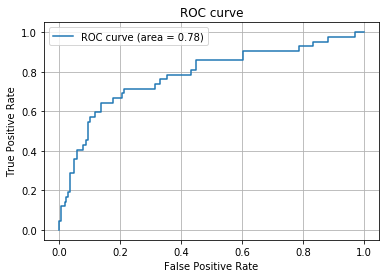

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7824739363200901

iter 50
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.552 0.051 0.343 0.054]


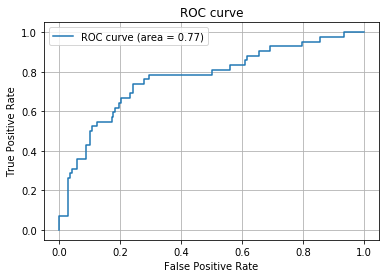

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.769512538743308

iter 51
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.22  0.321 0.224 0.234]


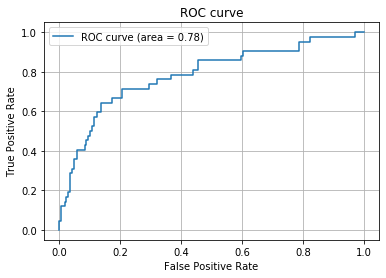

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7841645533953226

iter 52
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.357 0.034 0.261 0.348]


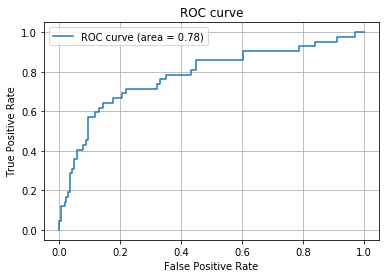

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7817695125387433

iter 53
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.464 0.065 0.375 0.096]


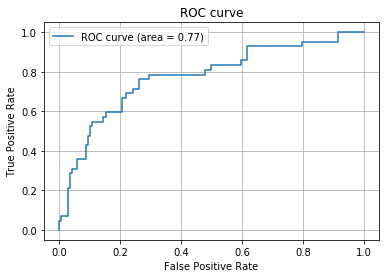

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7747252747252747

iter 54
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.23  0.623 0.029 0.117]


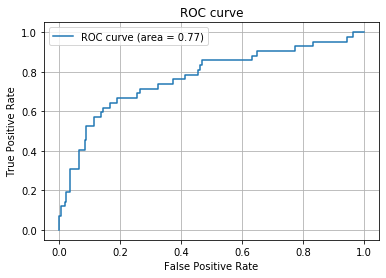

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7707805015497322

iter 55
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.196 0.747 0.047 0.01 ]


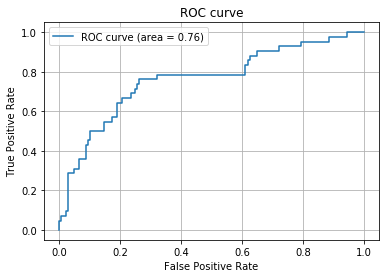

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7610594533671458

iter 56
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.099 0.378 0.397 0.126]


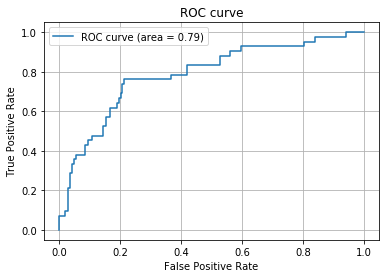

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.786559594251902

iter 57
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.201 0.288 0.199 0.313]


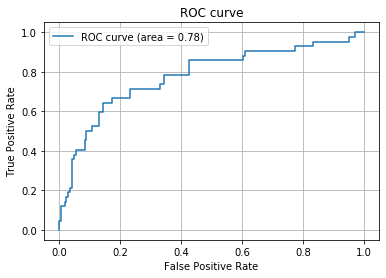

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7792335869258946

iter 58
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.324 0.245 0.255 0.175]


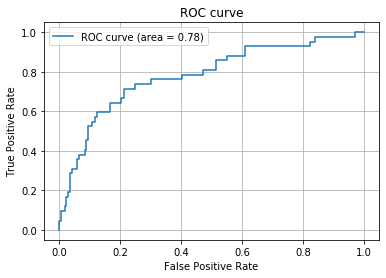

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7813468582699351

iter 59
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.212 0.387 0.321 0.08 ]


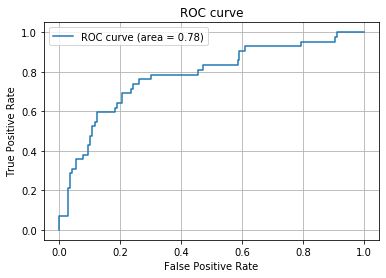

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7803606649760495

iter 60
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.181 0.237 0.39  0.192]


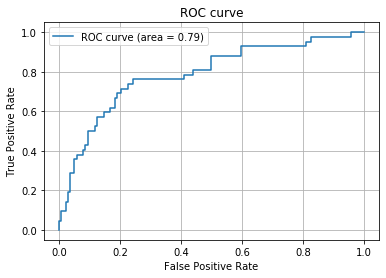

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7871231332769795

iter 61
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.089 0.206 0.242 0.464]


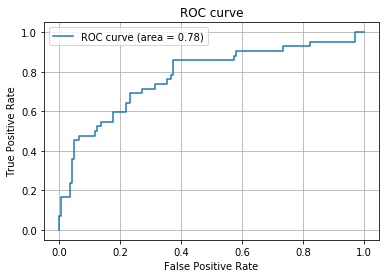

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7785291631445478

iter 62
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.097 0.343 0.361 0.198]


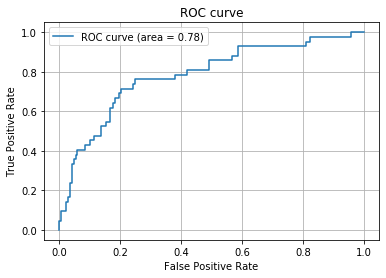

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7833192448577064

iter 63
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.319 0.317 0.063 0.3  ]


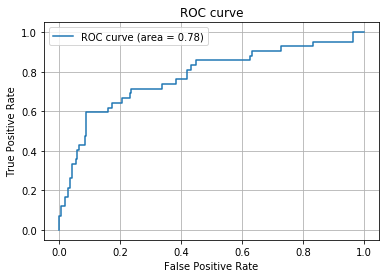

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7774020850943928

iter 64
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.289 0.371 0.21  0.13 ]


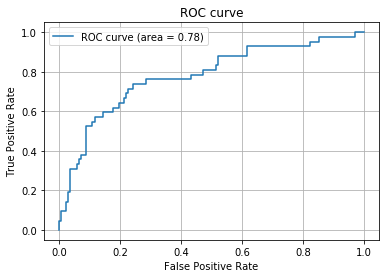

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7789518174133558

iter 65
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.377 0.146 0.112 0.365]


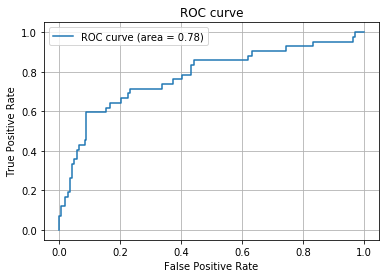

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7781065088757397

iter 66
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.376 0.296 0.179 0.15 ]


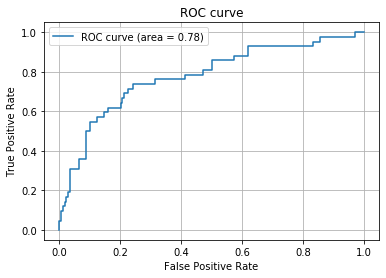

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7775429698506622

iter 67
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.082 0.403 0.33  0.186]


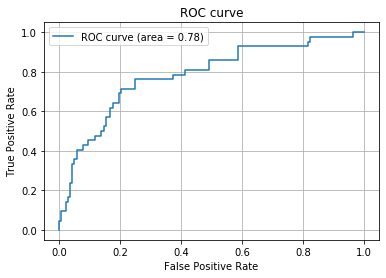

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7824739363200901

iter 68
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.027 0.387 0.35  0.235]


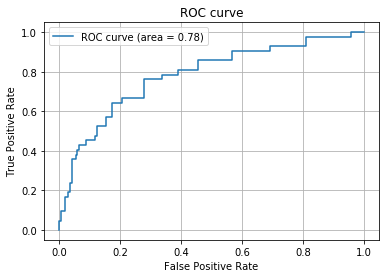

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7810650887573964

iter 69
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.228 0.337 0.274 0.162]


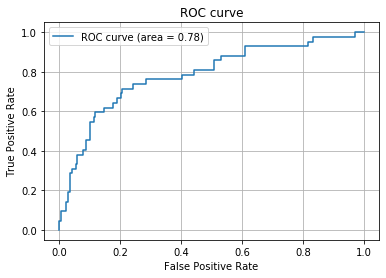

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7845872076641308

iter 70
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.05  0.36  0.235 0.354]


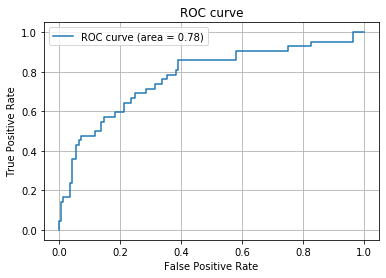

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7761341222879684

iter 71
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.284 0.025 0.395 0.297]


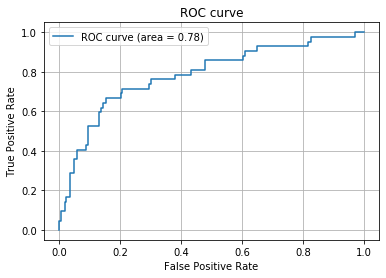

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7844463229078614

iter 72
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.317 0.192 0.287 0.204]


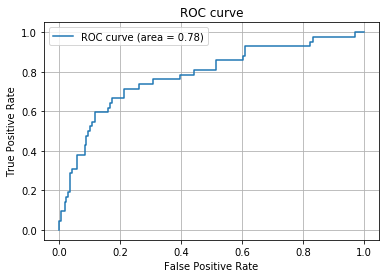

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.782051282051282

iter 73
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.041 0.266 0.259 0.435]


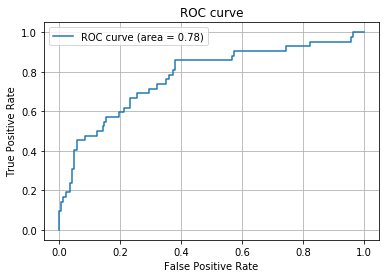

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7758523527754296

iter 74
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.071 0.331 0.475 0.123]


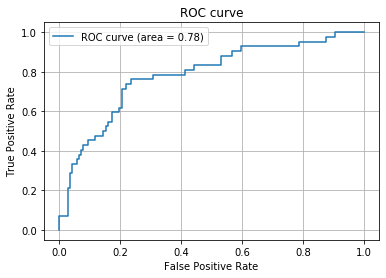

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7834601296139757

iter 75
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.118 0.021 0.523 0.338]


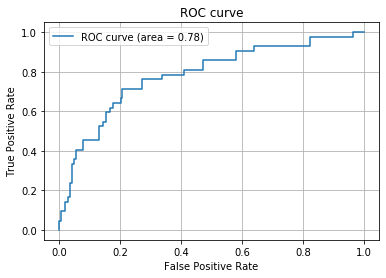

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7833192448577064

iter 76
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.052 0.503 0.31  0.135]


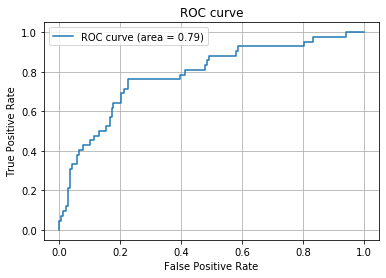

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7850098619329389

iter 77
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.3   0.011 0.56  0.129]


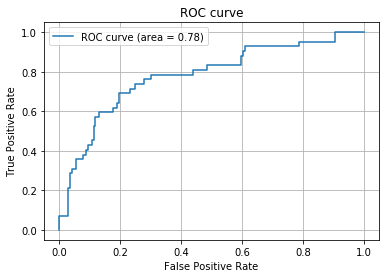

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7797971259509722

iter 78
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.001 0.041 0.518 0.439]


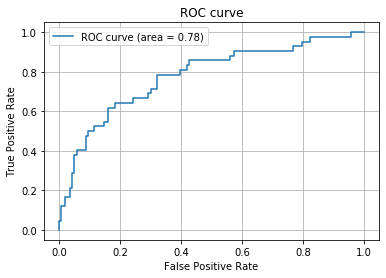

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7785291631445477

iter 79
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.049 0.196 0.415 0.34 ]


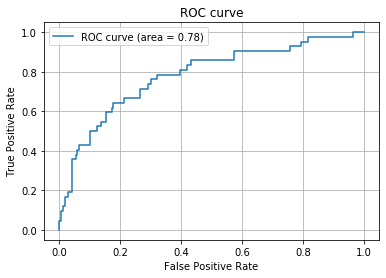

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7819103972950125

iter 80
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.434 0.103 0.016 0.447]


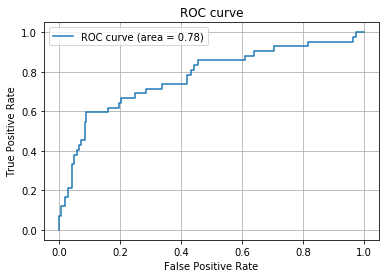

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7757114680191602

iter 81
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.083 0.203 0.373 0.342]


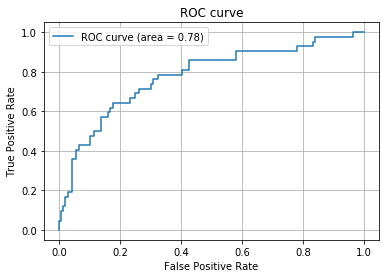

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7789518174133557

iter 82
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.369 0.308 0.145 0.179]


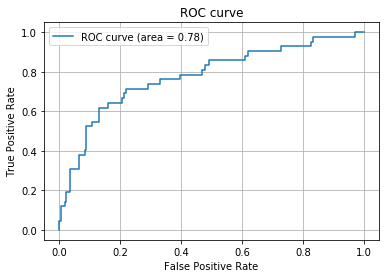

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7779656241194702

iter 83
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.17  0.213 0.221 0.397]


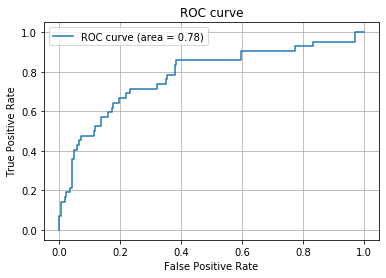

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.780924204001127

iter 84
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.309 0.511 0.067 0.112]


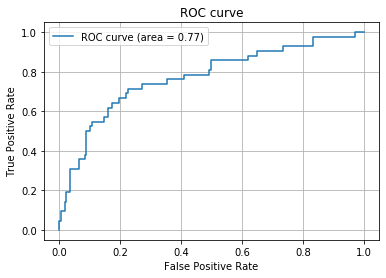

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7719075795998874

iter 85
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.521 0.169 0.033 0.277]


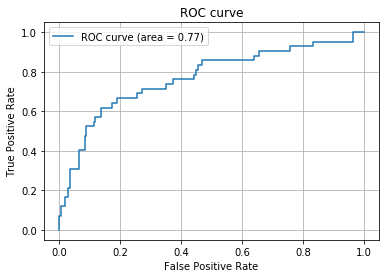

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7695125387433079

iter 86
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.057 0.184 0.233 0.526]


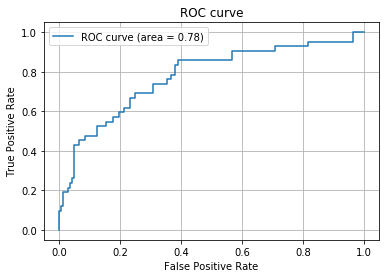

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7761341222879684

iter 87
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.275 0.379 0.129 0.217]


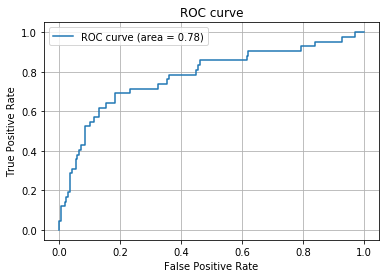

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7783882783882783

iter 88
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.141 0.121 0.37  0.368]


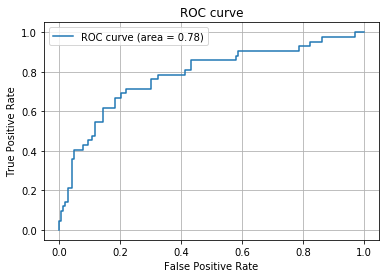

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7824739363200902

iter 89
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.103 0.37  0.057 0.469]


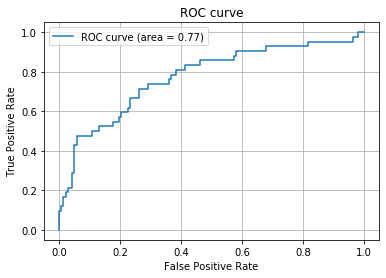

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7737390814313891

iter 90
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.37  0.077 0.256 0.297]


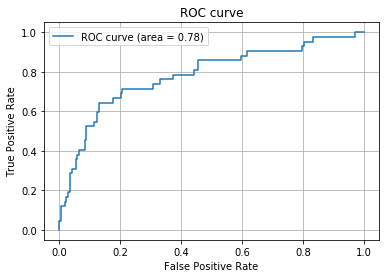

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7826148210763594

iter 91
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.298 0.245 0.274 0.183]


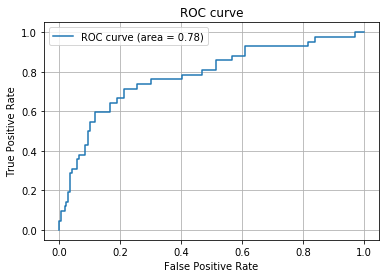

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7813468582699352

iter 92
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.337 0.334 0.145 0.184]


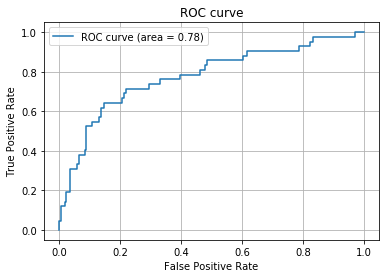

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7772612003381233

iter 93
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.042 0.101 0.418 0.439]


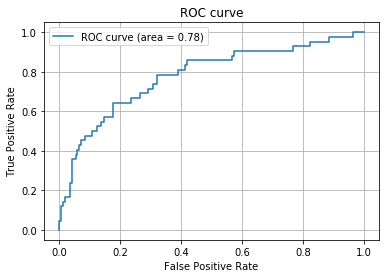

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7788109326570865

iter 94
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.158 0.226 0.484 0.133]


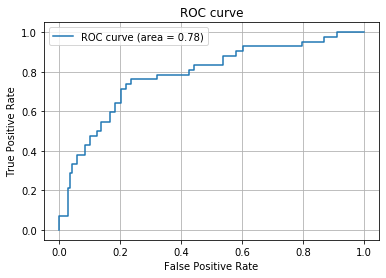

len: 211 , 211
confusion_matrix: 
[[150.  19.]
 [ 19.  23.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7848689771766696

iter 95
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.195 0.465 0.13  0.211]


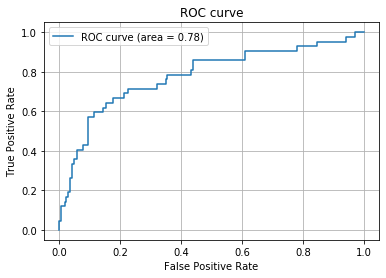

len: 211 , 211
confusion_matrix: 
[[148.  21.]
 [ 21.  21.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7799380107072416

iter 96
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.4   0.075 0.177 0.348]


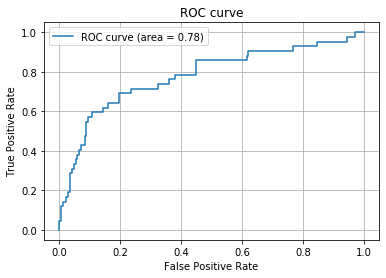

len: 211 , 211
confusion_matrix: 
[[149.  20.]
 [ 20.  22.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7783882783882784

iter 97
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.427 0.191 0.376 0.007]


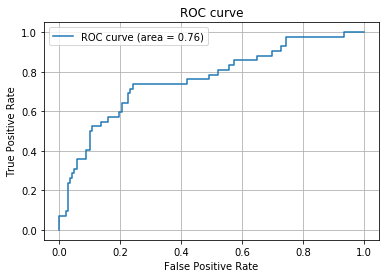

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7613412228796844

iter 98
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.34  0.202 0.27  0.188]


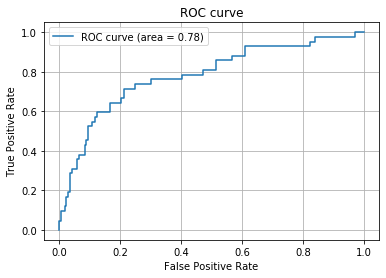

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7810650887573964

iter 99
[w_lda, w_lda, w_sv, w_xgb, w_lgbm] =  [0.414 0.425 0.042 0.119]


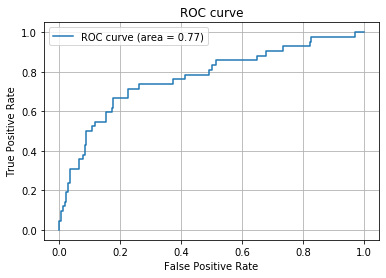

len: 211 , 211
confusion_matrix: 
[[151.  18.]
 [ 18.  24.]]
AUC LDA:  0.7418991265145111
AUC svm:  0.794590025359256
AUC xgb:  0.7607072414764722
AUC lgbm:  0.7602141448295294
AUC all:  0.7703578472809242

auc_max 0.7871231332769795
[0.181 0.237 0.39  0.192]


In [91]:
if __name__ == "__main__":
    main()

In [ ]:
# auc_max 0.7868413637644407
# [w_lr, w_lda, w_sv, w_xgb, w_lgbm]
# [0.098 0.143 0.314 0.324 0.122]
